<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V7_Tomato_model_not_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d manjuphoenix/tomatodataset

100% 922M/923M [00:48<00:00, 21.8MB/s]
100% 923M/923M [00:48<00:00, 20.2MB/s]


In [6]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a validation set is: 19488
The number of images in a test set is: 3904
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [20]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*64*64, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()


In [21]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=8, bias=True)
)

In [22]:
class EarlyStopping():
  """ Early stopping is used to stop the training process to avoid overfitting of the model when the loss does not improve after certain epochs"""
  def __init__(self, patience=6, min_delta=0):
      """
      Parameters:
      Patience: Number of epochs to wait before stopping when the loss is not improving
      min_delta: Minimum difference between new loss and the old loss for new loss to be considered as an improvement
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print("INFO: Early Stopping")
        self.early_stop = True

In [23]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
    print('\nEpoch : %d'%epoch)
    total_loss=0    
    correct=0
    total=0

    model.train()
    for data in tqdm(dataloader):
        inputs,labels=data[0].to(device),data[1].to(device)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    loss=total_loss/len(dataloader)
    accuracy=100.*correct/total
    
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.4f | Accuracy: %.4f'%(loss,accuracy))
    return loss, accuracy

In [24]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()
    total_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= loss_fn(outputs,labels)
            total_loss+=loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        loss=total_loss/len(dataloader)
        accuracy=100.*correct/total
        losses['val'].append(loss)
        accuracies['val'].append(accuracy)
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 
    return loss, accuracy

In [25]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.00001

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=350
early_stopping = EarlyStopping()
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model,loss_fn,train_loader,optimizer_ft,epoch)
  val_loss, val_accuracy = test(model,loss_fn,val_loader,epoch)
  early_stopping(val_loss)
  if early_stopping.early_stop:
    break


Epoch : 1


100%|██████████| 2841/2841 [04:05<00:00, 11.59it/s]


Train Loss: 2.0734 | Accuracy: 13.5772


100%|██████████| 609/609 [00:54<00:00, 11.27it/s]


Test Loss: 2.068 | Accuracy: 14.619

Epoch : 2


100%|██████████| 2841/2841 [04:12<00:00, 11.24it/s]


Train Loss: 2.0613 | Accuracy: 18.5051


100%|██████████| 609/609 [00:49<00:00, 12.26it/s]


Test Loss: 2.055 | Accuracy: 21.262

Epoch : 3


100%|██████████| 2841/2841 [03:57<00:00, 11.99it/s]


Train Loss: 2.0467 | Accuracy: 25.3514


100%|██████████| 609/609 [00:50<00:00, 12.12it/s]


Test Loss: 2.038 | Accuracy: 29.434

Epoch : 4


100%|██████████| 2841/2841 [03:59<00:00, 11.87it/s]


Train Loss: 2.0286 | Accuracy: 27.9958


100%|██████████| 609/609 [00:48<00:00, 12.44it/s]


Test Loss: 2.019 | Accuracy: 27.324

Epoch : 5


100%|██████████| 2841/2841 [04:03<00:00, 11.68it/s]


Train Loss: 2.0065 | Accuracy: 29.6073


100%|██████████| 609/609 [00:49<00:00, 12.36it/s]


Test Loss: 1.993 | Accuracy: 31.872

Epoch : 6


100%|██████████| 2841/2841 [04:03<00:00, 11.64it/s]


Train Loss: 1.9774 | Accuracy: 31.3002


100%|██████████| 609/609 [00:49<00:00, 12.24it/s]


Test Loss: 1.962 | Accuracy: 32.118

Epoch : 7


100%|██████████| 2841/2841 [04:01<00:00, 11.75it/s]


Train Loss: 1.9455 | Accuracy: 31.6291


100%|██████████| 609/609 [00:49<00:00, 12.35it/s]


Test Loss: 1.927 | Accuracy: 31.954

Epoch : 8


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 1.9061 | Accuracy: 33.3979


100%|██████████| 609/609 [00:50<00:00, 12.06it/s]


Test Loss: 1.890 | Accuracy: 35.737

Epoch : 9


100%|██████████| 2841/2841 [04:02<00:00, 11.71it/s]


Train Loss: 1.8719 | Accuracy: 34.4902


100%|██████████| 609/609 [00:49<00:00, 12.42it/s]


Test Loss: 1.858 | Accuracy: 36.353

Epoch : 10


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 1.8397 | Accuracy: 35.8365


100%|██████████| 609/609 [00:49<00:00, 12.31it/s]


Test Loss: 1.824 | Accuracy: 36.112

Epoch : 11


100%|██████████| 2841/2841 [04:02<00:00, 11.70it/s]


Train Loss: 1.8089 | Accuracy: 37.3809


100%|██████████| 609/609 [00:50<00:00, 12.05it/s]


Test Loss: 1.795 | Accuracy: 39.500

Epoch : 12


100%|██████████| 2841/2841 [04:03<00:00, 11.69it/s]


Train Loss: 1.7747 | Accuracy: 39.0551


100%|██████████| 609/609 [00:50<00:00, 12.15it/s]


Test Loss: 1.758 | Accuracy: 39.320

Epoch : 13


100%|██████████| 2841/2841 [04:05<00:00, 11.55it/s]


Train Loss: 1.7456 | Accuracy: 40.1936


100%|██████████| 609/609 [00:49<00:00, 12.32it/s]


Test Loss: 1.733 | Accuracy: 41.009

Epoch : 14


100%|██████████| 2841/2841 [04:05<00:00, 11.56it/s]


Train Loss: 1.7168 | Accuracy: 41.6038


100%|██████████| 609/609 [00:51<00:00, 11.90it/s]


Test Loss: 1.705 | Accuracy: 42.400

Epoch : 15


100%|██████████| 2841/2841 [04:04<00:00, 11.60it/s]


Train Loss: 1.6921 | Accuracy: 42.3540


100%|██████████| 609/609 [00:50<00:00, 12.07it/s]


Test Loss: 1.687 | Accuracy: 43.247

Epoch : 16


100%|██████████| 2841/2841 [04:00<00:00, 11.83it/s]


Train Loss: 1.6739 | Accuracy: 43.3231


100%|██████████| 609/609 [00:48<00:00, 12.49it/s]


Test Loss: 1.660 | Accuracy: 44.515

Epoch : 17


100%|██████████| 2841/2841 [03:58<00:00, 11.89it/s]


Train Loss: 1.6559 | Accuracy: 44.0161


100%|██████████| 609/609 [00:48<00:00, 12.47it/s]


Test Loss: 1.644 | Accuracy: 44.987

Epoch : 18


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 1.6367 | Accuracy: 44.7432


100%|██████████| 609/609 [00:49<00:00, 12.37it/s]


Test Loss: 1.626 | Accuracy: 45.013

Epoch : 19


100%|██████████| 2841/2841 [04:00<00:00, 11.80it/s]


Train Loss: 1.6142 | Accuracy: 45.5714


100%|██████████| 609/609 [00:49<00:00, 12.19it/s]


Test Loss: 1.611 | Accuracy: 45.906

Epoch : 20


100%|██████████| 2841/2841 [04:00<00:00, 11.82it/s]


Train Loss: 1.6025 | Accuracy: 46.1665


100%|██████████| 609/609 [00:48<00:00, 12.56it/s]


Test Loss: 1.600 | Accuracy: 46.420

Epoch : 21


100%|██████████| 2841/2841 [03:57<00:00, 11.95it/s]


Train Loss: 1.5815 | Accuracy: 46.8100


100%|██████████| 609/609 [00:49<00:00, 12.31it/s]


Test Loss: 1.575 | Accuracy: 47.179

Epoch : 22


100%|██████████| 2841/2841 [03:55<00:00, 12.04it/s]


Train Loss: 1.5680 | Accuracy: 47.3083


100%|██████████| 609/609 [00:48<00:00, 12.57it/s]


Test Loss: 1.567 | Accuracy: 47.359

Epoch : 23


100%|██████████| 2841/2841 [03:56<00:00, 12.03it/s]


Train Loss: 1.5582 | Accuracy: 47.4579


100%|██████████| 609/609 [00:48<00:00, 12.47it/s]


Test Loss: 1.553 | Accuracy: 48.052

Epoch : 24


100%|██████████| 2841/2841 [03:54<00:00, 12.12it/s]


Train Loss: 1.5486 | Accuracy: 47.6889


100%|██████████| 609/609 [00:48<00:00, 12.68it/s]


Test Loss: 1.535 | Accuracy: 47.862

Epoch : 25


100%|██████████| 2841/2841 [03:55<00:00, 12.06it/s]


Train Loss: 1.5268 | Accuracy: 48.3819


100%|██████████| 609/609 [00:48<00:00, 12.56it/s]


Test Loss: 1.524 | Accuracy: 48.170

Epoch : 26


100%|██████████| 2841/2841 [03:55<00:00, 12.08it/s]


Train Loss: 1.5189 | Accuracy: 48.6415


100%|██████████| 609/609 [00:47<00:00, 12.71it/s]


Test Loss: 1.514 | Accuracy: 49.145

Epoch : 27


100%|██████████| 2841/2841 [03:57<00:00, 11.98it/s]


Train Loss: 1.5025 | Accuracy: 49.0826


100%|██████████| 609/609 [00:48<00:00, 12.63it/s]


Test Loss: 1.496 | Accuracy: 49.494

Epoch : 28


100%|██████████| 2841/2841 [03:56<00:00, 12.00it/s]


Train Loss: 1.4847 | Accuracy: 49.3510


100%|██████████| 609/609 [00:48<00:00, 12.57it/s]


Test Loss: 1.481 | Accuracy: 49.951

Epoch : 29


100%|██████████| 2841/2841 [03:57<00:00, 11.94it/s]


Train Loss: 1.4705 | Accuracy: 49.6634


100%|██████████| 609/609 [00:48<00:00, 12.58it/s]


Test Loss: 1.466 | Accuracy: 50.737

Epoch : 30


100%|██████████| 2841/2841 [03:52<00:00, 12.19it/s]


Train Loss: 1.4559 | Accuracy: 50.3520


100%|██████████| 609/609 [00:47<00:00, 12.72it/s]


Test Loss: 1.454 | Accuracy: 50.141

Epoch : 31


100%|██████████| 2841/2841 [03:54<00:00, 12.09it/s]


Train Loss: 1.4406 | Accuracy: 50.4851


100%|██████████| 609/609 [00:47<00:00, 12.84it/s]


Test Loss: 1.440 | Accuracy: 50.192

Epoch : 32


100%|██████████| 2841/2841 [03:58<00:00, 11.93it/s]


Train Loss: 1.4263 | Accuracy: 51.0274


100%|██████████| 609/609 [00:48<00:00, 12.54it/s]


Test Loss: 1.425 | Accuracy: 51.358

Epoch : 33


100%|██████████| 2841/2841 [03:59<00:00, 11.84it/s]


Train Loss: 1.4146 | Accuracy: 51.1440


100%|██████████| 609/609 [00:48<00:00, 12.43it/s]


Test Loss: 1.410 | Accuracy: 51.250

Epoch : 34


100%|██████████| 2841/2841 [04:00<00:00, 11.81it/s]


Train Loss: 1.4110 | Accuracy: 51.1275


100%|██████████| 609/609 [00:48<00:00, 12.48it/s]


Test Loss: 1.410 | Accuracy: 50.896
INFO: Early stopping counter 1 of 6

Epoch : 35


100%|██████████| 2841/2841 [03:57<00:00, 11.98it/s]


Train Loss: 1.3895 | Accuracy: 51.7831


100%|██████████| 609/609 [00:49<00:00, 12.34it/s]


Test Loss: 1.385 | Accuracy: 50.829

Epoch : 36


100%|██████████| 2841/2841 [03:55<00:00, 12.09it/s]


Train Loss: 1.3779 | Accuracy: 52.0449


100%|██████████| 609/609 [00:48<00:00, 12.43it/s]


Test Loss: 1.377 | Accuracy: 52.128

Epoch : 37


100%|██████████| 2841/2841 [03:55<00:00, 12.06it/s]


Train Loss: 1.3752 | Accuracy: 52.1736


100%|██████████| 609/609 [00:48<00:00, 12.53it/s]


Test Loss: 1.370 | Accuracy: 52.636

Epoch : 38


100%|██████████| 2841/2841 [03:55<00:00, 12.09it/s]


Train Loss: 1.3640 | Accuracy: 52.6576


100%|██████████| 609/609 [00:48<00:00, 12.45it/s]


Test Loss: 1.366 | Accuracy: 51.625

Epoch : 39


100%|██████████| 2841/2841 [03:56<00:00, 12.03it/s]


Train Loss: 1.3487 | Accuracy: 52.9469


100%|██████████| 609/609 [00:48<00:00, 12.61it/s]


Test Loss: 1.360 | Accuracy: 52.687

Epoch : 40


100%|██████████| 2841/2841 [03:54<00:00, 12.12it/s]


Train Loss: 1.3516 | Accuracy: 52.6675


100%|██████████| 609/609 [00:49<00:00, 12.28it/s]


Test Loss: 1.343 | Accuracy: 52.559

Epoch : 41


100%|██████████| 2841/2841 [03:56<00:00, 12.02it/s]


Train Loss: 1.3381 | Accuracy: 53.4254


100%|██████████| 609/609 [00:48<00:00, 12.52it/s]


Test Loss: 1.338 | Accuracy: 52.913

Epoch : 42


100%|██████████| 2841/2841 [03:55<00:00, 12.04it/s]


Train Loss: 1.3277 | Accuracy: 53.7818


100%|██████████| 609/609 [00:48<00:00, 12.52it/s]


Test Loss: 1.321 | Accuracy: 53.088

Epoch : 43


 57%|█████▋    | 1618/2841 [02:14<02:25,  8.42it/s]

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v4_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v4_tomato_scripted.pt') # Save

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Class accuracies using Validation Dataset**

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

**Class Accuracies using Test Dataset**

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

**Confusion Matrix using Validation Dataset:**

[[331   3   8  85   3   0  19   8]
 [  3 359  16  20   5   4  70   5]
 [ 15  40 384  20   4   2  23   8]
 [ 27   3   5 386   3   3  33   5]
 [  1   4   1   1 487  12   5   0]
 [  1  11   0   1  16 468   4   0]
 [ 14  57  21  37   6   3 354   0]
 [ 11  11   2  16   2   0   0 451]]
[72.42888403 74.4813278  77.41935484 83.01075269 95.30332681 93.41317365
 71.95121951 91.48073022]


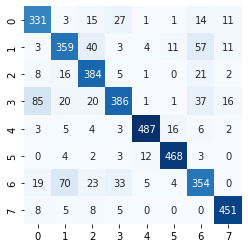

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)

**Confusion Matrix using Test Dataset:**

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes,  cmap='Blues', fmt='d', cbar=False)